### Generate and test feature likelihood SOM using comsoDC2 sample

We will be using the `cosmoDC2_v1.1.4_small_photoz_magerr_10y_small` sample, accessible via GCR. A description of this catalog is provided here:

https://confluence.slac.stanford.edu/display/LSSTDESC/List+of+available+DC2+catalogs+created+by+PhotoZ

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('../python')

import os
import time
import som

import pandas as pd
import seaborn as sns

from astropy.table import Table
from matplotlib.colors import LogNorm

In [3]:
from GCR import GCRQuery
import GCRCatalogs

In [4]:
seed = 44
rng = np.random.RandomState(seed)

In [5]:
pz_path = '/global/cscratch1/sd/belaa/lsst/repos/pz_bayes/data/feature_likelihood/'

Set `reload = True` if the catalog has already been written. Otherwise set to `False`.

In [6]:
reload = True

In [7]:
if reload:
    gc_table = Table.read(os.path.join(pz_path, 'dc2_small_photoz_magerr_10y_cuts.fits'), format='fits')
    dc2_colors = Table.read(os.path.join(pz_path, 'dc2_small_10y_colors.fits'), format='fits')
    
else:
    # Load catalog
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_photoz_magerr_10y')
    
    # Define coordinate cuts
    
    # 4 x 4 sq deg patch
    deg = 4 
    # alpha = cos<DEC>, where DEC is the average declination of our patch
    alpha = 0.78 
    beta = (0.5 * deg) * (1/alpha - 1)

    ra_min = 62.5 - beta
    ra_max = 66.5 + beta
    dec_min = -41.
    dec_max = -37.

    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max),
    ]
    
    # Define magnitude cuts
    mag_filters = [
    'scatmag_u < 26.3',
    'scatmag_g < 26.3',
    'scatmag_r < 26.3',
    'scatmag_i < 25.0',
    ]
    
    # Add derived quantitites
    
    def get_colors(mag1, mag2):
        return(mag1 - mag2)

    # Diff between mag_<band>_true and mag_<band>_lsst?
    gc.add_derived_quantity('u-g_true', get_colors, 'mag_u_lsst', 'mag_g_lsst')
    gc.add_derived_quantity('g-r_true', get_colors, 'mag_g_lsst', 'mag_r_lsst')
    gc.add_derived_quantity('r-i_true', get_colors, 'mag_r_lsst', 'mag_i_lsst')
    gc.add_derived_quantity('i-z_true', get_colors, 'mag_i_lsst', 'mag_z_lsst')
    gc.add_derived_quantity('z-y_true', get_colors, 'mag_z_lsst', 'mag_y_lsst')

    gc.add_derived_quantity('u-g_scat', get_colors, 'scatmag_u', 'scatmag_g')
    gc.add_derived_quantity('g-r_scat', get_colors, 'scatmag_g', 'scatmag_r')
    gc.add_derived_quantity('r-i_scat', get_colors, 'scatmag_r', 'scatmag_i')
    gc.add_derived_quantity('i-z_scat', get_colors, 'scatmag_i', 'scatmag_z')
    gc.add_derived_quantity('z-y_scat', get_colors, 'scatmag_z', 'scatmag_y')
    
    gc_cut = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 
                            'mag_z_lsst', 'mag_y_lsst', 'scatmag_u', 'scatmag_g', 'scatmag_r', 'scatmag_i', 
                           'scatmag_z', 'scatmag_y', 'u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true', 
                           'u-g_scat', 'g-r_scat', 'r-i_scat', 'i-z_scat', 'z-y_scat'], 
                           filters=(coord_filters + mag_filters))
    # Write catalog
    gc_table = Table(gc_cut)
    gc_table.write(os.path.join(pz_path, 'dc2_small_photoz_magerr_10y_cuts.fits'), format='fits')
    
    # Write colors table
    colors = np.asarray([gc_cut['u-g_true'], gc_cut['g-r_true'], gc_cut['r-i_true'], gc_cut['i-z_true'], gc_cut['z-y_true']]).T
    dc2_colors = Table(colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
    dc2_colors.write(os.path.join(pz_path, 'dc2_small_10y_colors.fits'), format='fits')

#### Let's take a look at the data post-cuts:

In [87]:
gc_df = pd.DataFrame(np.array(gc_table))
gc_size = len(gc_df['redshift'])

print('There are {} galaxies left after magnitude and ra/dec cuts.'.format(gc_size))
# Want to be around 50-60 per sq arcmin
print('There are {} targets per sq arcmin.'.format(gc_size / (16 * 3600)))

There are 1613192 galaxies left after magnitude and ra/dec cuts.
There are 28.006805555555555 targets per sq arcmin.


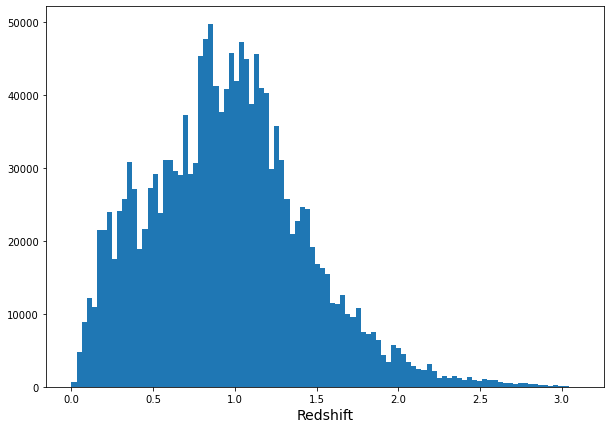

In [42]:
# Check for stars
plt.figure(figsize=(10,7))
plt.hist(gc_df['redshift'], bins=100)
plt.xlabel('Redshift', fontsize=14);

Add a digitized redshift column:

In [95]:
nzbins = 10
zbins = np.percentile(gc_df['redshift'], np.linspace(0, 100, nzbins + 1))
zbins[-1] += 1
iz = np.digitize(gc_df['redshift'], zbins) - 1
assert np.all((iz >= 0) & (iz < nzbins))
gc_df['iz'] = iz

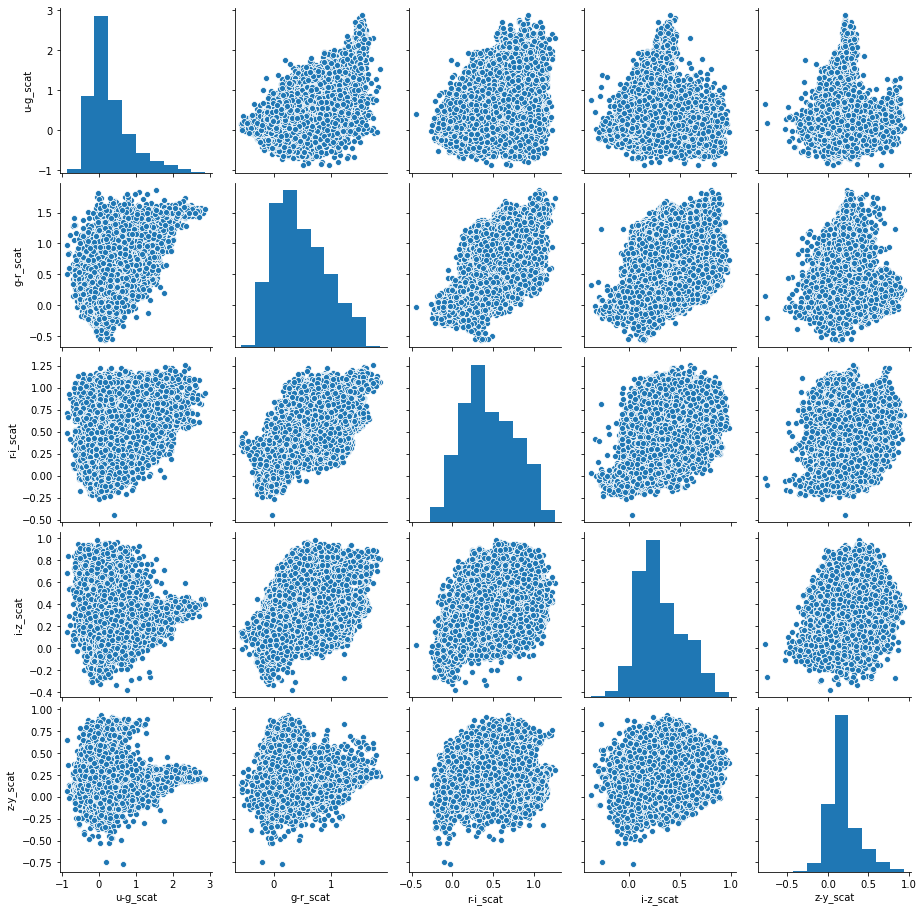

In [53]:
# Magnitude cuts look reasonable...
sns.pairplot(gc_df[['u-g_scat', 'g-r_scat', 'r-i_scat', 'i-z_scat', 'z-y_scat']][::100]);

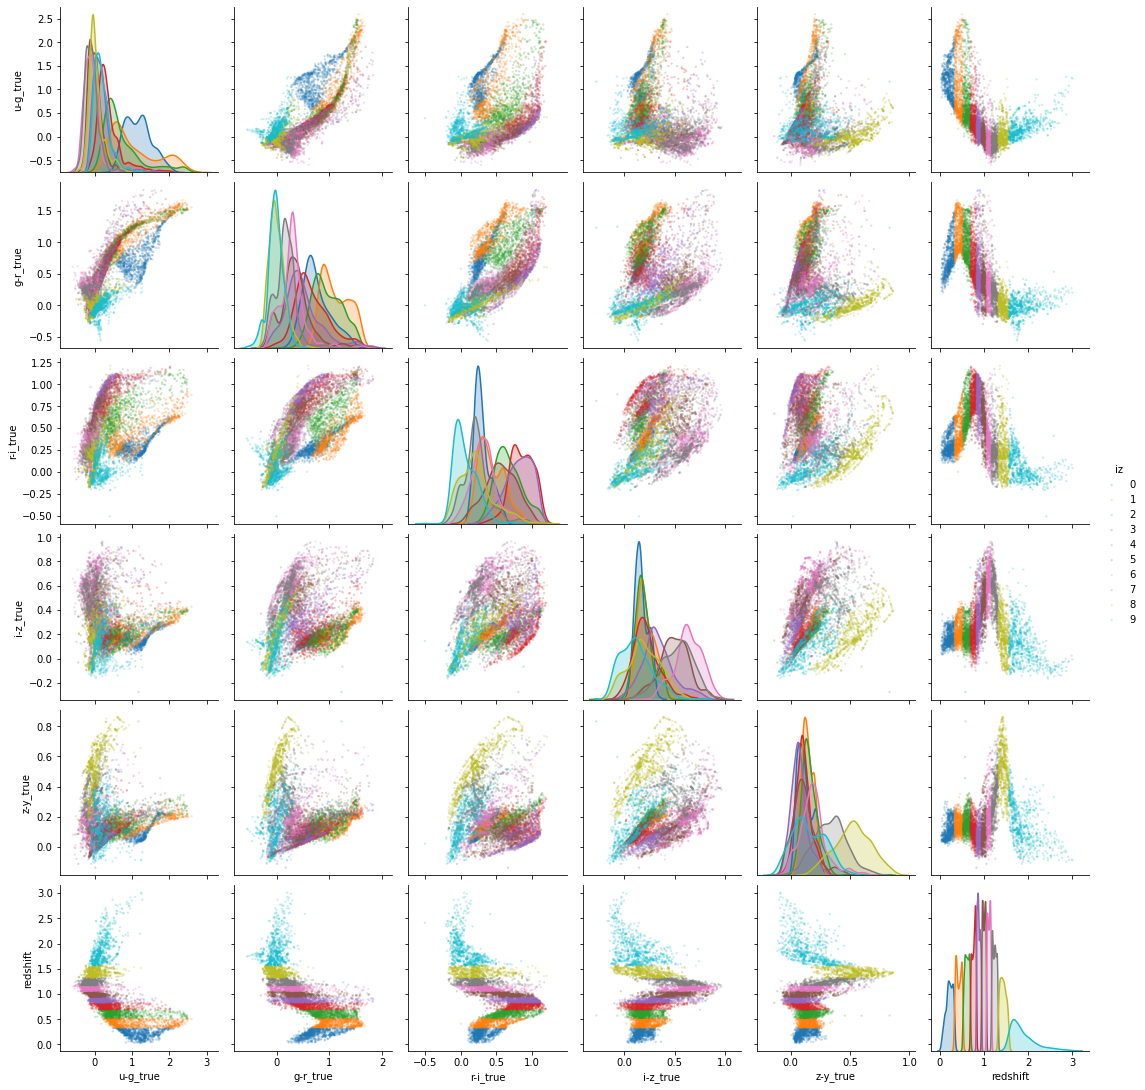

In [57]:
sns.pairplot(gc_df[::200], vars=['u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true', 'redshift'],
             hue='iz', plot_kws=dict(edgecolor='none', alpha=0.25, s=5), diag_kind='kde');

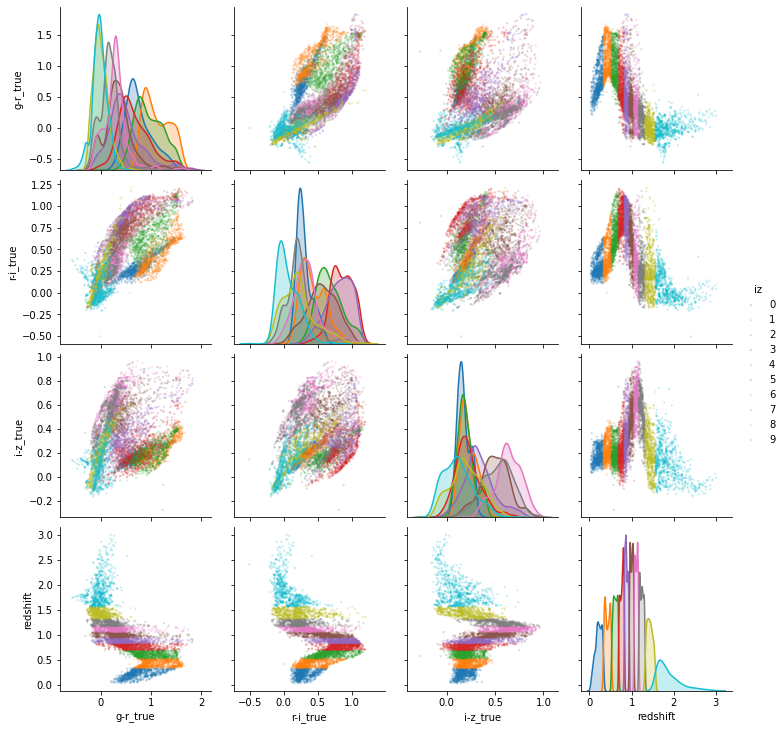

In [97]:
sns.pairplot(gc_df[['g-r_true', 'r-i_true', 'i-z_true', 'redshift', 'iz']][::200], vars=['g-r_true', 'r-i_true', 'i-z_true', 'redshift'],
             hue='iz', plot_kws=dict(edgecolor='none', alpha=0.25, s=5), diag_kind='kde');

In [8]:
gc_table = Table.read(os.path.join(pz_path, 'dc2_processed_table.fits'), format='fits')
griz_table = Table([gc_table['g-r_true'], gc_table['r-i_true'], gc_table['i-z_true'], gc_table['redshift']], 
                   names=['g-r', 'r-i', 'i-z', 'redshift'])

Split data into train, validation and test sets:

In [9]:
def split(x, train_size, random_state):

    # Assert valid values for train size
    assert np.logical_and(train_size > 0., train_size < 1.)
    
    N = len(x)
    ntrain = int(train_size * N)
    
    # Generate random indices 
    random_indices = random_state.choice(N, N, replace=False)
    
    # Get train and test indices
    train_indices = random_indices[:ntrain]
    test_indices = random_indices[ntrain:]
    
    return(x[train_indices], x[test_indices])

In [10]:
data = griz_table[::20]

In [11]:
train, test = split(data, 0.8, rng)
#train, val = split(train, 0.7, rng)

In [12]:
len(train), len(test)

(64528, 16132)

Look at redshift distribution for each set:

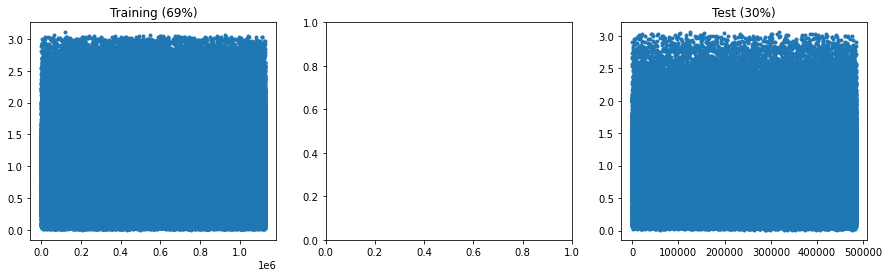

In [78]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()

axs[0].plot(train['redshift'], '.')
axs[0].set_title('Training ({}%)'.format(int(len(train) / len(data) * 100)))
#axs[1].plot(val['redshift'], '.')
#axs[1].set_title('Validation ({}%)'.format(int(len(val) / len(data) * 100)))
axs[2].plot(test['redshift'], '.')
axs[2].set_title('Test ({}%)'.format(int(len(test) / len(data) * 100)));

Train SOM on training set:

In [13]:
nside = 30
niter = 20

In [14]:
X = train[['g-r', 'r-i', 'i-z']]
Y = np.asarray(train['redshift'])

Try: slower learning rate, more iterations?

For training set of size 65334 galaxies:

- 50 iterations takes 24 seconds (15 x 15 grid): max galaxies / cell around 200
- 90 iterations takes 42 seconds (15 x 15 grid): max gals / cell around 170
- 100 iterations takes 47 seconds (same): max gals / cell around 250
- 30 iterations takes 38 seconds (30 x 30 grid): max gals / cell around 50
- 90 iterations takes 70 seconds (30 x 30 grid): max gals / cell around 50
- 120 iterations takes 93 seconds (30 x 30 grid): max gals / cell around 50

For training set of size 1129234 galaxies:
- 30 iterations takes 3298 seconds (30 x 30 grid): max gals / cell around 6000

In [15]:
start = time.time()
som_train = som.SelfOrganizingMap(som.Grid(-nside, -nside))
som_train.fit(X, maxiter=niter)
som_train.map_to_som(X, Y)
print(time.time() - start)

106.18048405647278


In [21]:
np.min(Y), np.max(Y)

(0.01845216806085559, 3.0295514139705517)

In [46]:
bb = np.linspace(0, 3.2, 100)

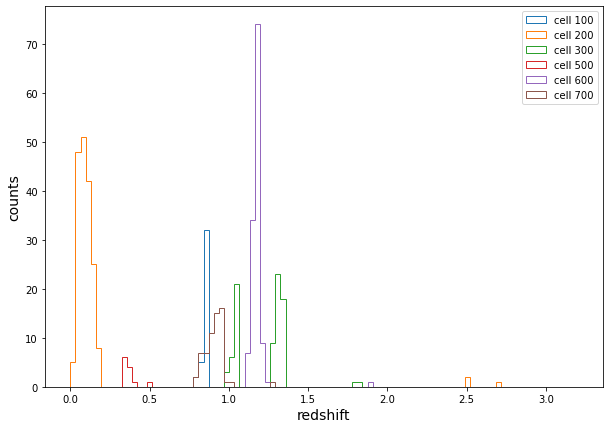

In [47]:
plt.figure(figsize=(10,7))
#plt.hist(som_train._target_dist[0],   bins=bb, histtype='step', label='cell 0')
plt.hist(som_train._target_dist[100], bins=bb, histtype='step', label='cell 100')
plt.hist(som_train._target_dist[200], bins=bb, histtype='step', label='cell 200')
plt.hist(som_train._target_dist[300], bins=bb, histtype='step', label='cell 300')
#plt.hist(som_train._target_dist[400], bins=bb, histtype='step', label='cell 400')
plt.hist(som_train._target_dist[500], bins=bb, histtype='step', label='cell 500')
plt.hist(som_train._target_dist[600], bins=bb, histtype='step', label='cell 600')
plt.hist(som_train._target_dist[700], bins=bb, histtype='step', label='cell 700')
#plt.hist(som_train._target_dist[800], bins=bb, histtype='step', label='cell 800')
plt.xlabel('redshift', fontsize=14)
plt.ylabel('counts', fontsize=14)
plt.legend();

Map training data back to SOM:

In [60]:
som_train.map_to_som(X,Y)

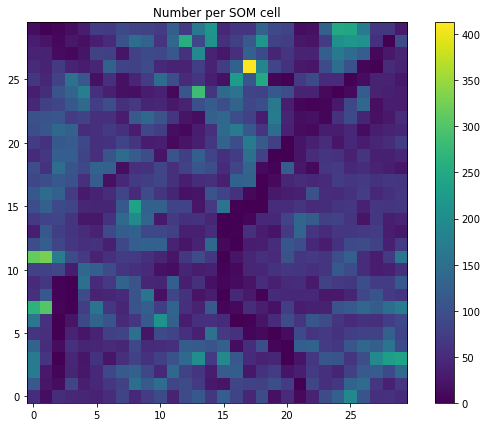

In [17]:
som_train.plot_counts_per_cell()

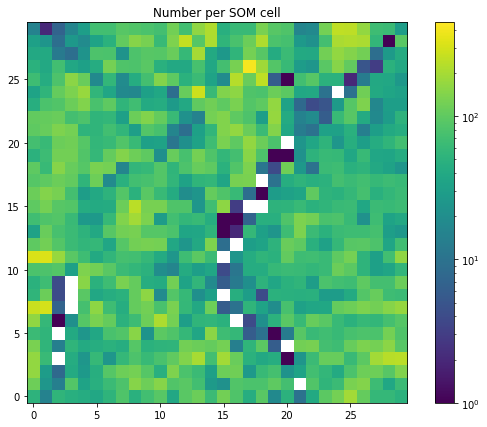

In [18]:
som_train.plot_counts_per_cell(norm=LogNorm(vmin=1, vmax=450))

../python/som.py:310: RuntimeWarning: Mean of empty slice
  stat = np.asarray([statistic(self._target_dist[i]) for i in range(self._mapgeom.size)])


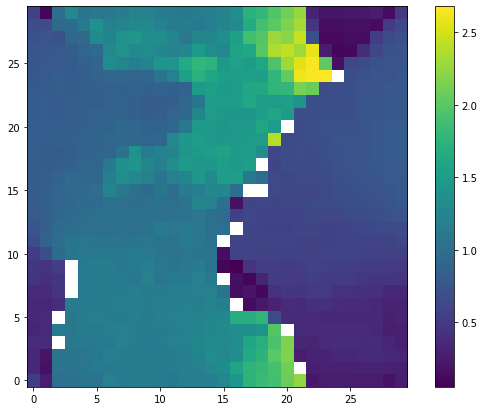

In [19]:
# Need to handle empty cells
som_train.plot_statistic()

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


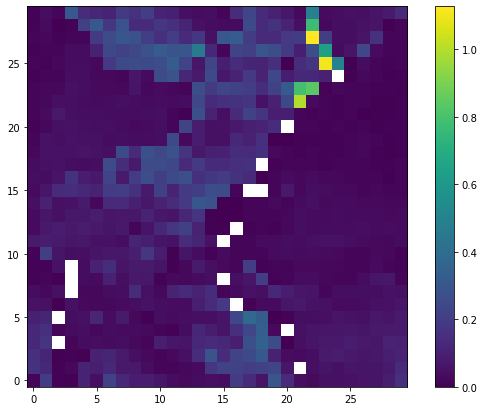

In [26]:
som_train.plot_statistic(statistic=np.nanstd)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


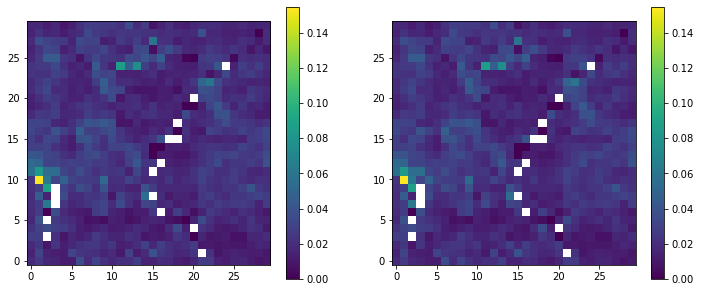

In [22]:
som_train.plot_statistic(feature=[0], statistic=np.nanstd)

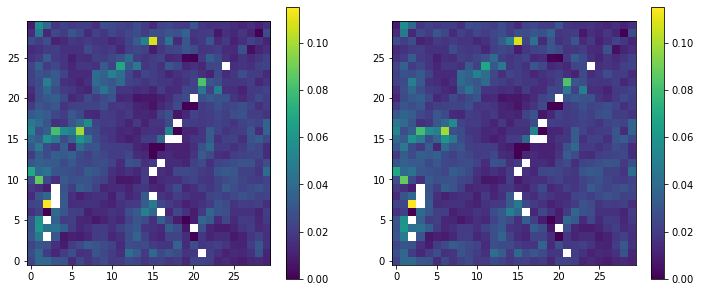

In [23]:
som_train.plot_statistic(feature=[1], statistic=np.nanstd)

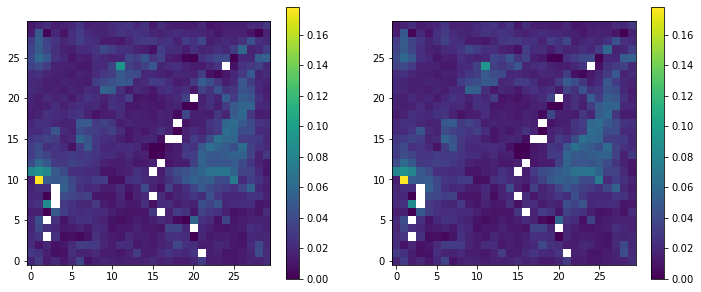

In [24]:
som_train.plot_statistic(feature=[2], statistic=np.nanstd)

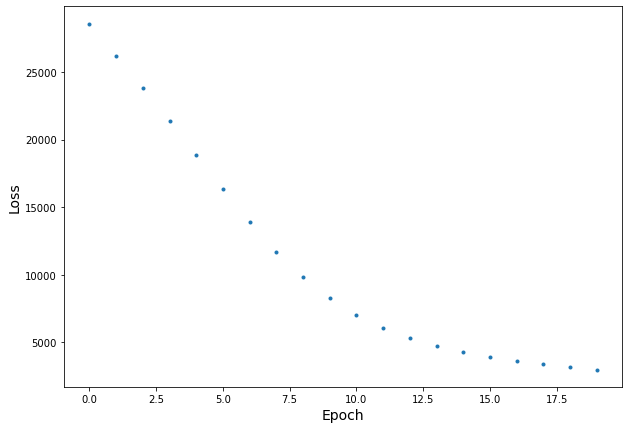

In [16]:
plt.figure(figsize=(10,7))
plt.plot(som_train._loss, '.')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14);

In [61]:
pred = [np.mean(som_train._target_dist[best]) for best in som_train.find_bmu(som.table_to_array(X))]
rms = [np.std(som_train._target_dist[best]) for best in som_train.find_bmu(som.table_to_array(X))]

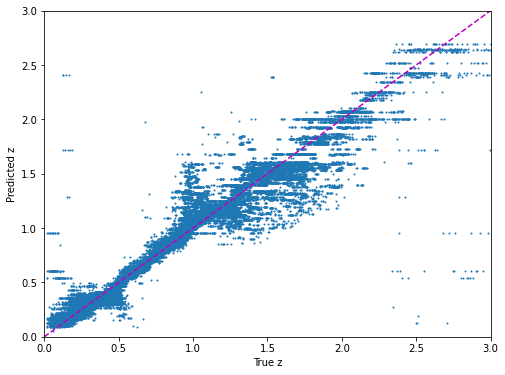

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(Y, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

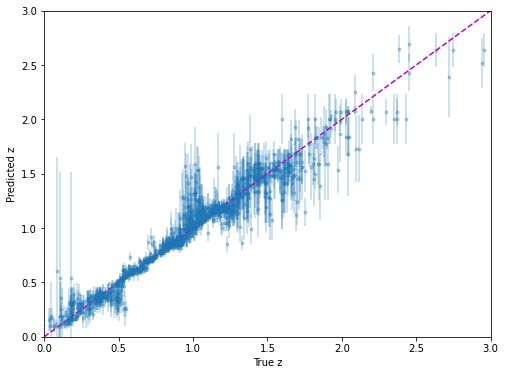

In [65]:
chunks = 50
plt.figure(figsize=(8,6))
plt.errorbar(x=Y[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

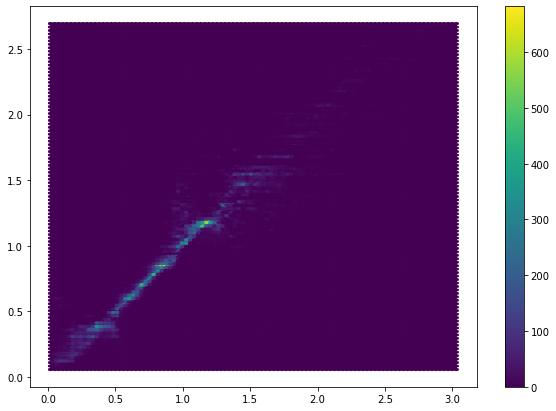

In [64]:
plt.figure(figsize=(10,7))
plt.hexbin(Y, pred, gridsize=(100,100))
plt.colorbar();

Map test set back to SOM:

In [21]:
X_test = test[['g-r', 'r-i', 'i-z']]
Y_test = np.asarray(test['redshift'])

In [22]:
len(X_test)

16132

In [66]:
som_train.map_to_som(X_test,Y_test)

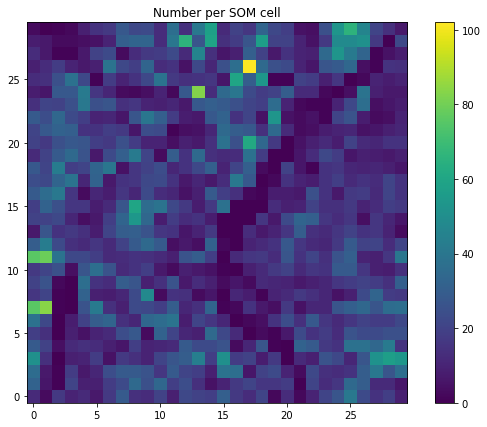

In [127]:
som_train.plot_counts_per_cell()

In [71]:
bmus = som_train.find_bmu(som.table_to_array(X_test))

In [72]:
pred = [np.mean(som_train._target_dist[bmus[i]]) for i in range(len(bmus))]
rms = [np.std(som_train._target_dist[bmus[i]]) for i in range(len(bmus))]

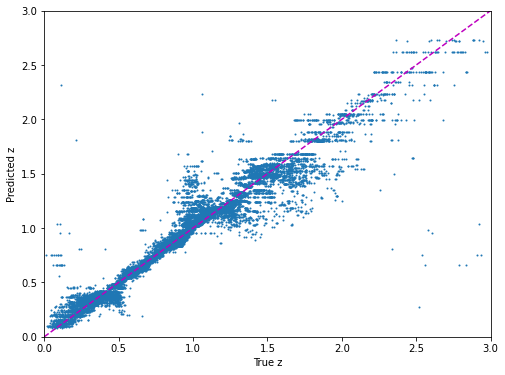

In [73]:
plt.figure(figsize=(8,6))
plt.scatter(Y_test, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

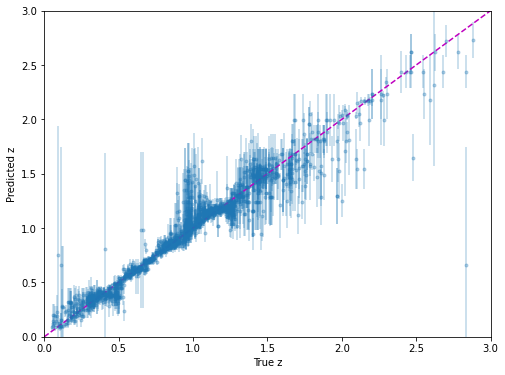

In [74]:
chunks = 10
plt.figure(figsize=(8,6))
plt.errorbar(x=Y_test[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

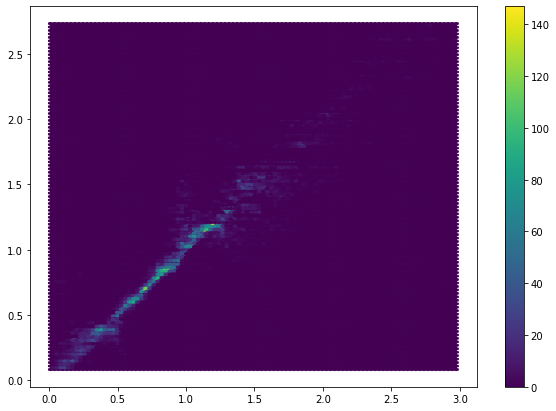

In [76]:
plt.figure(figsize=(10,7))
plt.hexbin(Y_test, pred, gridsize=(100,100))
plt.colorbar();

Compare to SOMz:

In [77]:
# This is lifted from the SOMz module from: http://matias-ck.com/mlz/somz.html

def get_index(ix, iy, nx, ny):
    return iy * nx + ix


def get_pair(ii, nx, ny):
    iy = int(numpy.floor(ii / nx))
    ix = ii % nx
    return ix, iy


def get_ns(ix, iy, nx, ny, index=False):
    """
    Get neighbors for rectangular grid given its
    coordinates and size of grid

    :param int ix: Coordinate in the x-axis
    :param int iy: Coordinate in the y-axis
    :param int nx: Number fo cells along the x-axis
    :param int ny: Number fo cells along the y-axis
    :param bool index: Return indexes in the map format
    :return: Array of indexes for direct neighbors
    """
    ns = []
    if ix - 1 >= 0: ns.append((ix - 1, iy))
    if iy - 1 >= 0: ns.append((ix, iy - 1))
    if ix + 1 < nx: ns.append((ix + 1, iy))
    if iy + 1 < ny: ns.append((ix, iy + 1))

    if ix - 1 >= 0 and iy - 1 >= 0: ns.append((ix - 1, iy - 1))
    if ix - 1 >= 0 and iy + 1 < ny: ns.append((ix - 1, iy + 1))
    if ix + 1 < nx and iy + 1 < ny: ns.append((ix + 1, iy + 1))
    if ix + 1 < nx and iy - 1 >= 0: ns.append((ix + 1, iy - 1))

    ns = numpy.array(ns)
    if not index:
        return ns
    if index:
        ins = []
        for i in range(len(ns)):
            ins.append(get_index(ns[i, 0], ns[i, 1], nx, ny))
        return numpy.array(ins)


def get_ns_hex(ix, iy, nx, ny, index=False):
    """
    Get neighbors for hexagonal grid given its coordinates
    and size of grid
    Same parameters as :func:`get_ns`
    """
    ns = []
    even = False
    if iy % 2 == 0: even = True
    if ix - 1 >= 0: ns.append((ix - 1, iy))
    if ix + 1 < nx: ns.append((ix + 1, iy))
    if iy - 1 >= 0: ns.append((ix, iy - 1))
    if iy + 1 < ny: ns.append((ix, iy + 1))
    if even and ix - 1 >= 0 and iy - 1 >= 0: ns.append((ix - 1, iy - 1))
    if even and ix - 1 >= 0 and iy + 1 < ny: ns.append((ix - 1, iy + 1))
    if not even and ix + 1 < nx and iy - 1 >= 0: ns.append((ix + 1, iy - 1))
    if not even and ix + 1 < nx and iy + 1 < ny: ns.append((ix + 1, iy + 1))
    ns = numpy.array(ns)
    if not index:
        return ns
    if index:
        ins = []
        for i in range(len(ns)):
            ins.append(get_index(ns[i, 0], ns[i, 1], nx, ny))
        return numpy.array(ins)


def geometry(top, Ntop, periodic='no'):
    """
    Pre-compute distances between cells in a given topology
    and store it on a distLib array

    :param str top: Topology ('grid','hex','sphere')
    :param int Ntop: Size of map,  for grid Size=Ntop*Ntop,
        for hex Size=Ntop*(Ntop+1[2]) if Ntop is even[odd] and for sphere
        Size=12*Ntop*Ntop and top must be power of 2
    :param str periodic: Use periodic boundary conditions ('yes'/'no'), valid for 'hex' and 'grid' only
    :return: 2D array with distances pre computed between cells and total number of units
    :rtype: 2D float array, int
    """
    if top == 'sphere':
        try:
            import healpy as hpx
        except:
            print('Error: healpy module not found, use grid or hex topologies')
            sys.exit(0)
    if top == 'sphere':
        nside = Ntop
        npix = 12 * nside ** 2
        distLib = numpy.zeros((npix, npix))
        for i in range(npix):
            ai = hpx.pix2ang(nside, i)
            for j in range(i + 1, npix):
                aj = hpx.pix2ang(nside, j)
                distLib[i, j] = hpx.rotator.angdist(ai, aj)
                distLib[j, i] = distLib[i, j]
        distLib[numpy.where(numpy.isnan(distLib))] = numpy.pi
    if top == 'grid':
        nx = Ntop
        ny = Ntop
        npix = nx * ny
        mapxy = numpy.mgrid[0:1:complex(0, nx), 0:1:complex(0, ny)]
        mapxy = numpy.reshape(mapxy, (2, npix))
        bX = mapxy[1]
        bY = mapxy[0]
        dx = 1. / (nx - 1)
        dy = 1. / (ny - 1)
        distLib = numpy.zeros((npix, npix))
        if periodic == 'no':
            for i in range(npix):
                for j in range(i + 1, npix):
                    distLib[i, j] = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    distLib[j, i] = distLib[i, j]
        if periodic == 'yes':
            for i in range(npix):
                for j in range(i + 1, npix):
                    s0 = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    s1 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - bY[j]) ** 2)
                    s2 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s3 = numpy.sqrt((bX[i] - (bX[j] + 0.)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s4 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s5 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] + 0.)) ** 2)
                    s6 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    s7 = numpy.sqrt((bX[i] - (bX[j] + 0.)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    s8 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    distLib[i, j] = numpy.min((s0, s1, s2, s3, s4, s5, s6, s7, s8))
                    distLib[j, i] = distLib[i, j]
    if top == 'hex':
        nx = Ntop
        ny = Ntop
        xL = numpy.arange(0, nx, 1.)
        dy = 0.8660254
        yL = numpy.arange(0, ny, dy)
        ny = len(yL)
        nx = len(xL)
        npix = nx * ny
        bX = numpy.zeros(nx * ny)
        bY = numpy.zeros(nx * ny)
        kk = 0
        last = ny * dy
        for jj in range(ny):
            for ii in range(nx):
                if jj % 2 == 0: off = 0.
                if jj % 2 == 1: off = 0.5
                bX[kk] = xL[ii] + off
                bY[kk] = yL[jj]
                kk += 1
        distLib = numpy.zeros((npix, npix))
        if periodic == 'no':
            for i in range(npix):
                for j in range(i + 1, npix):
                    distLib[i, j] = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    distLib[j, i] = distLib[i, j]
        if periodic == 'yes':
            for i in range(npix):
                for j in range(i + 1, npix):
                    s0 = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    s1 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - bY[j]) ** 2)
                    s2 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s3 = numpy.sqrt((bX[i] - (bX[j] + 0)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s4 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s5 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] + 0)) ** 2)
                    s6 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    s7 = numpy.sqrt((bX[i] - (bX[j] + 0)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    s8 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    distLib[i, j] = numpy.min((s0, s1, s2, s3, s4, s5, s6, s7, s8))
                    distLib[j, i] = distLib[i, j]
    return distLib, npix


def is_power_2(value):
    """
    Check if passed value is a power of 2
    """
    return value!=0 and ((value & (value- 1)) == 0)


def get_alpha(t, alphas, alphae, NT):
    """
    Get value of alpha at a given time
    """
    return alphas * numpy.power(alphae / alphas, float(t) / float(NT))


def get_sigma(t, sigma0, sigmaf, NT):
    """
    Get value of sigma at a given time
    """
    return sigma0 * numpy.power(sigmaf / sigma0, float(t) / float(NT))


def h(bmu, mapD, sigma):
    """
    Neighborhood function which quantifies how much cells around the best matching one are modified

    :param int bmu: best matching unit
    :param float mapD: array of distances computed with :func:`geometry`
    """
    return numpy.exp(-(mapD[bmu] ** 2) / sigma ** 2)

In [78]:
class SelfMap():
    """
    Create a som class instance

    :param float X: Attributes array (all columns used)
    :param float Y: Attribute to be predicted (not really needed, can be zeros)
    :param str topology: Which 2D topology, 'grid', 'hex' or 'sphere'
    :param str som_type: Which updating scheme to use 'online' or 'batch'
    :param int Ntop: Size of map,  for grid Size=Ntop*Ntop,
        for hex Size=Ntop*(Ntop+1[2]) if Ntop is even[odd] and for sphere
        Size=12*Ntop*Ntop and top must be power of 2
    :param  int iterations: Number of iteration the entire sample is processed
    :param str periodic: Use periodic boundary conditions ('yes'/'no'), valid for 'hex' and 'grid' only
    :param dict dict_dim: dictionary with attributes names
    :param float astar: Initial value of alpha
    :param float aend: End value of alpha
    :param str importance: Path to the file with importance ranking for attributes, default is none
    """

    def __init__(self, X, Y, topology='grid', som_type='online', Ntop=28, iterations=30, periodic='no', dict_dim='',
                 astart=0.8, aend=0.5, importance=None):
        self.np, self.nDim = numpy.shape(X)
        self.dict_dim = dict_dim
        self.X = X
        self.Y = Y
        self.aps = astart
        self.ape = aend
        self.top = topology
        if topology=='sphere' and not is_power_2(Ntop):
            print('Error, Ntop must be power of 2')
            sys.exit(0)
        self.stype = som_type
        self.Ntop = Ntop
        self.nIter = iterations
        self.per = periodic
        self.distLib, self.npix = geometry(self.top, self.Ntop, periodic=self.per)
        if importance == None: importance = numpy.ones(self.nDim)
        self.importance = importance / numpy.sum(importance)
        # Added
        #self.store_weights = np.empty((self.nIter, self.np, self.nDim, self.npix))
        self.loss = np.empty(self.nIter)

    def som_best_cell(self, inputs, return_vals=1):
        """
        Return the closest cell to the input object
        It can return more than one value if needed
        """
        activations = numpy.sum(numpy.transpose([self.importance]) * (
            numpy.transpose(numpy.tile(inputs, (self.npix, 1))) - self.weights) ** 2, axis=0)
        if return_vals == 1:
            best = numpy.argmin(activations)
            return best, activations
        else:
            best_few = numpy.argsort(activations)
            return best_few[0:return_vals], activations

    def create_map(self, evol='no', inputs_weights='', seed=123):
        """
        This is same as above but uses python routines instead
        """
        
        # Added
        rng = np.random.RandomState(seed=seed)
        
        if inputs_weights == '':
            # Added
            self.weights = rng.random_sample(size=(self.nDim, self.npix)) + self.X[0][0]
            #self.weights = (numpy.random.rand(self.nDim, self.npix)) + self.X[0][0]
        else:
            self.weights = inputs_weights
        self.NT = self.nIter * self.np
        if self.stype == 'online':
            tt = 0
            sigma0 = self.distLib.max()
            sigma_single = numpy.min(self.distLib[numpy.where(self.distLib > 0.)])
            # Added
            #self.store_weights = np.empty((self.nIter, self.np, self.nDim, self.npix))
            for it in range(self.nIter):
                #get alpha, sigma
                alpha = get_alpha(tt, self.aps, self.ape, self.NT)
                sigma = get_sigma(tt, sigma0, sigma_single, self.NT)
                #index_random = random.sample(range(self.np), self.np)
                # Added
                index_random = rng.choice(np.arange(self.np), size=self.np, replace=False)
                loss = 0.
                for i in range(self.np):
                    tt += 1
                    inputs = self.X[index_random[i]]
                    # Added
                    #inputs = self.X[i]
                    best, activation = self.som_best_cell(inputs)
                    dx = numpy.transpose(
                        (inputs - numpy.transpose(self.weights)))
                    loss += np.sqrt(np.sum(dx ** 2, axis=0))[best]
                    self.weights += alpha * h(best, self.distLib, sigma) * dx
                    # Added
                    #self.store_weights[it,i] = self.weights
                self.loss[it] = loss
                if evol == 'yes':
                    self.evaluate_map()
                    self.save_map(itn=it)
        if self.stype == 'batch':
            tt = 0
            sigma0 = self.distLib.max()
            sigma_single = numpy.min(self.distLib[numpy.where(self.distLib > 0.)])
            for it in range(self.nIter):
                #get alpha, sigma
                sigma = get_sigma(tt, sigma0, sigma_single, self.NT)
                accum_w = numpy.zeros((self.nDim, self.npix))
                accum_n = numpy.zeros(self.npix)
                for i in range(self.np):
                    tt += 1
                    inputs = self.X[i]
                    best, activation = self.som_best_cell(inputs)
                    for kk in range(self.nDim):
                        accum_w[kk, :] += h(best, self.distLib, sigma) * inputs[kk]
                    accum_n += h(best, self.distLib, sigma)
                for kk in range(self.nDim):
                    self.weights[kk] = accum_w[kk] / accum_n

                if evol == 'yes':
                    self.evaluate_map()
                    self.save_map(itn=it)

    def evaluate_map(self, inputX='', inputY=''):
        """
        This functions evaluates the map created using the input Y or a new Y (array of labeled attributes)
        It uses the X array passed or new data X as well, the map doesn't change

        :param float inputX: Use this if another set of values for X is wanted using
            the weigths already computed
        :param float inputY: One  dimensional array of the values to be assigned to each cell in the map
            based on the in-memory X passed
        """
        self.yvals = {}
        self.ivals = {}
        if inputX == '':
            inX = self.X
        else:
            inX = inputX
        if inputY == '':
            inY = self.Y
        else:
            inY = inputY
        for i in range(len(inX)):
            inputs = inX[i]
            best, activation = self.som_best_cell(inputs)
            if not best in self.yvals: self.yvals[best] = []
            self.yvals[best].append(inY[i])
            if not best in self.ivals: self.ivals[best] = []
            self.ivals[best].append(i)

    def get_vals(self, line):
        """
        Get the predictions  given a line search, where the line
        is a vector of attributes per individual object fot the
        10 closest cells.

        :param float line: input data to look in the tree
        :return: array with the cell content
        """
        best, act = self.som_best_cell(line, return_vals=10)
        for ib in range(10):
            if best[ib] in self.yvals: return self.yvals[best[ib]]
        return numpy.array([-1.])

    def get_best(self, line):
        """
        Get the predictions  given a line search, where the line
        is a vector of attributes per individual object for THE best cell

        :param float line: input data to look in the tree
        :return: array with the cell content
        """
        best, act = self.som_best_cell(line, return_vals=10)
        return best[0]

    def save_map(self, itn=-1, fileout='SOM', path=''):
        """
        Saves the map

        :param int itn: Number of map to be included on path, use -1 to ignore this number
        :param str fileout: Name of output file
        :param str path: path for the output file
        """
        if path == '':
            path = os.getcwd() + '/'
        if not os.path.exists(path): os.system('mkdir -p ' + path)
        if itn >= 0:
            ff = '_%04d' % itn
            fileout += ff
        numpy.save(path + fileout, self)

    def save_map_dict(self, path='', fileout='SOM', itn=-1):
        """
        Saves the map in dictionary format

        :param int itn: Number of map to be included on path, use -1 to ignore this number
        :param str fileout: Name of output file
        :param str path: path for the output file
        """
        SOM = {}
        SOM['W'] = self.weights
        SOM['yvals'] = self.yvals
        SOM['ivals'] = self.ivals
        SOM['topology'] = self.top
        SOM['Ntop'] = self.Ntop
        SOM['npix'] = self.npix
        if path == '':
            path = os.getcwd() + '/'
        if not os.path.exists(path): os.system('mkdir -p ' + path)
        if itn > 0:
            ff = '_%04d' % itn
            fileout += ff
        numpy.save(path + fileout, SOM)

    def plot_map(self, min_m=-100, max_m=-100, colbar='yes'):
        """
        Plots the map after evaluating, the cells are colored with the mean value inside each
        one of them

        :param float min_m: Lower limit for coloring the cells, -100 uses min value
        :param float max_m: Upper limit for coloring the cells, -100 uses max value
        :param str colbar: Include a colorbar ('yes','no')
        """

        import matplotlib.pyplot as plt
        #from matplotlib import mpl
        # see https://stackoverflow.com/questions/44499971/importerror-cannot-import-name-mpl-from-matplotlib-import-mpl
        import matplotlib as mpl
        import matplotlib.cm as cm
        from matplotlib import collections, transforms
        from matplotlib.colors import colorConverter

        if self.top == 'sphere': import healpy as H

        if self.top == 'grid':
            M = numpy.zeros(self.npix) - 20.
            S = numpy.zeros(self.npix)
            for i in range(self.npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
                    S[i] = numpy.std(self.yvals[i])
            M2 = numpy.reshape(M, (self.Ntop, self.Ntop))
            S2 = numpy.reshape(S, (self.Ntop, self.Ntop))
            #plt.figure(figsize=(8, 8), dpi=100)
            fig, axs = plt.subplots(1,2, figsize=(12,5))
            axs = axs.ravel()
            if min_m == -100: min_m = M2[numpy.where(M2 > -10)].min()
            min_s = S2[numpy.where(S2 > -10)].min()
            if max_m == -100: max_m = M2.max()
            max_s = S2.max() 
            #SM2 = plt.imshow(M2, origin='center', interpolation='nearest', cmap=cm.jet, vmin=min_m, vmax=max_m)
            #SM2.cmap.set_under("grey")
            im0 = axs[0].imshow(M2, origin='lower', interpolation='none', cmap='viridis', vmin=min_m, vmax=max_m)
            im1 = axs[1].imshow(S2, origin='lower', interpolation='none', cmap='viridis', vmin=min_s, vmax=max_s)
            fig.colorbar(im0, ax=axs[0])
            fig.colorbar(im1, ax=axs[1])
            #if colbar == 'yes': plt.colorbar()
            plt.axis('off')
        if self.top == 'hex':
            nx = self.Ntop
            ny = self.Ntop
            xL = numpy.arange(0, nx, 1.)
            dy = 0.8660254
            yL = numpy.arange(0, ny, dy)
            ny = len(yL)
            nx = len(xL)
            npix = nx * ny
            bX = numpy.zeros(nx * ny)
            bY = numpy.zeros(nx * ny)
            kk = 0
            for jj in range(ny):
                for ii in range(nx):
                    if jj % 2 == 0: off = 0.
                    if jj % 2 == 1: off = 0.5
                    bX[kk] = xL[ii] + off
                    bY[kk] = yL[jj]
                    kk += 1
            xyo = list(zip(bX, bY))
            sizes_2 = numpy.zeros(nx * ny) + ((8. * 0.78 / (self.Ntop + 0.5)) / 2. * 72.) ** 2 * 4. * numpy.pi / 3.
            M = numpy.zeros(npix) - 20.
            fcolors = [plt.cm.Spectral_r(x) for x in numpy.random.rand(nx * ny)]
            for i in range(npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
            if max_m == -100: max_m = M.max()
            if min_m == -100: min_m = M[numpy.where(M > -10)].min()
            M = M - min_m
            M = M / (max_m - min_m)
            for i in range(npix):
                if M[i] <= 0:
                    fcolors[i] = plt.cm.Greys(.5)
                else:
                    fcolors[i] = plt.cm.jet(M[i])
            figy = ((8. * 0.78 / (self.Ntop + 0.5) / 2.) * (3. * ny + 1) / numpy.sqrt(3)) / 0.78
            fig3 = plt.figure(figsize=(8, figy), dpi=100)
            #fig3.subplots_adjust(left=0,right=1.,top=1.,bottom=0.)
            a = fig3.add_subplot(1, 1, 1)
            col = collections.RegularPolyCollection(6, sizes=sizes_2, offsets=xyo, transOffset=a.transData)
            col.set_color(fcolors)
            a.add_collection(col, autolim=True)
            a.set_xlim(-0.5, nx)
            a.set_ylim(-1, nx + 0.5)
            plt.axis('off')
            if colbar == 'yes':
                figbar = plt.figure(figsize=(8, 1.), dpi=100)
                ax1 = figbar.add_axes([0.05, 0.8, 0.9, 0.15])
                cmap = cm.jet
                norm = mpl.colors.Normalize(vmin=min_m, vmax=max_m)
                cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal')
                cb1.set_label('')
        if self.top == 'sphere':
            M = numpy.zeros(self.npix) + H.UNSEEN
            for i in range(self.npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
            plt.figure(10, figsize=(8, 8), dpi=100)
            if min_m == -100: min_m = M[numpy.where(M > -10)].min()
            if max_m == -100: max_m = M.max()
            if colbar == 'yes': H.mollview(M, fig=10, title="", min=min_m, max=max_m, cbar=True)
            if colbar == 'no': H.mollview(M, fig=10, title="", min=min_m, max=max_m, cbar=False)
        plt.show()

206.51882696151733


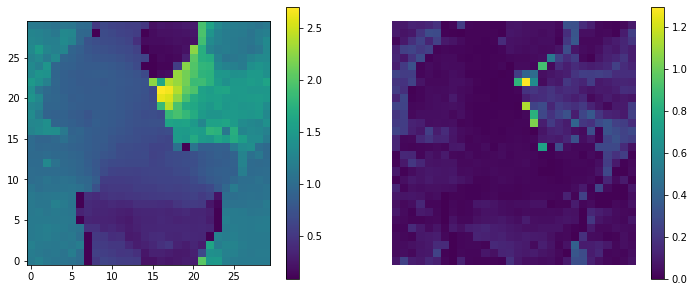

In [79]:
start = time.time()
M = SelfMap(som.table_to_array(X),Y,Ntop=nside,iterations=niter,periodic='yes')
M.create_map()
M.evaluate_map()
print(time.time() - start)
M.plot_map()

In [80]:
def plot_somz_counts():
    
    # Plot counts per cell
    counts = np.zeros(nside ** 2, dtype=int)
    for i in range(nside **2): 
        try:
            counts[i] = len(M.yvals[i])
        except KeyError:
            pass
        
    plt.figure(figsize=(10,7))
    plt.imshow(counts.reshape(nside,nside), origin='lower', cmap='viridis')
    plt.title('Number per SOM cell')
    plt.colorbar();
    
def plot_somz_loss():
    
    plt.figure(figsize=(10,7))
    plt.plot(M.loss, '.')
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14);
    
def plot_somz_feature(data, feature=0, statistic=np.nanmean):
    
    cell_stat = []
    cell_feature = []
    for i in range(nside ** 2):
        try:
            diff = data[M.ivals[i]] - M.weights.T[i]
            cell_stat.append(statistic(diff, axis=0)[feature])
        except KeyError:
            cell_stat.append(np.nan)
        try:
            cell_feature.append(statistic(data[M.ivals[i]], axis=0)[feature])
        except KeyError:
            cell_feature.append(np.nan)
            
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs = axs.ravel()
    
    im0 = axs[0].imshow(np.array(cell_feature).reshape(nside,nside), origin='lower', interpolation='none')
    #axs[0].set_title('Mean of feature {}'.format(feature))
    fig.colorbar(im0, ax=axs[0])
    
    im1 = axs[1].imshow(np.array(cell_stat).reshape(nside,nside), origin='lower', interpolation='none')
    #axs[1].set_title('Mean(data - node weights) for feature {}'.format(feature))
    fig.colorbar(im1, ax=axs[1])
    
    plt.show()

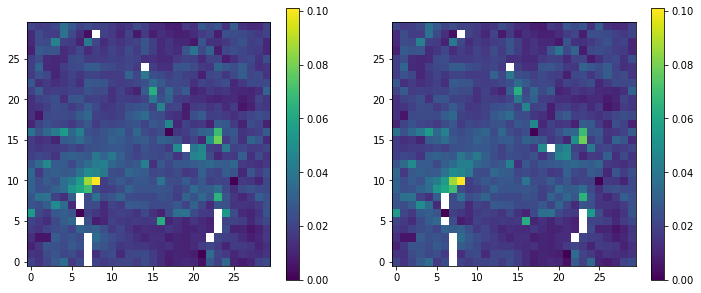

In [82]:
plot_somz_feature(som.table_to_array(X), feature=0, statistic=np.nanstd)

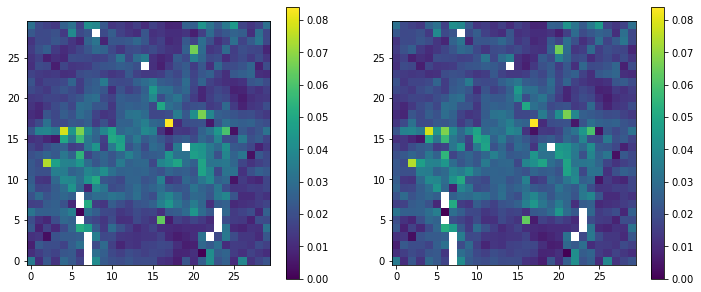

In [84]:
plot_somz_feature(som.table_to_array(X), feature=1, statistic=np.nanstd)

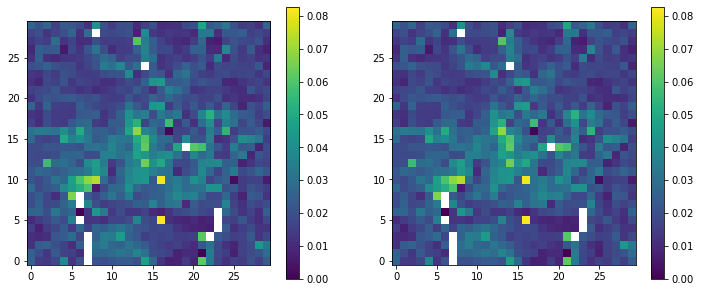

In [86]:
plot_somz_feature(som.table_to_array(X), feature=2, statistic=np.nanstd)

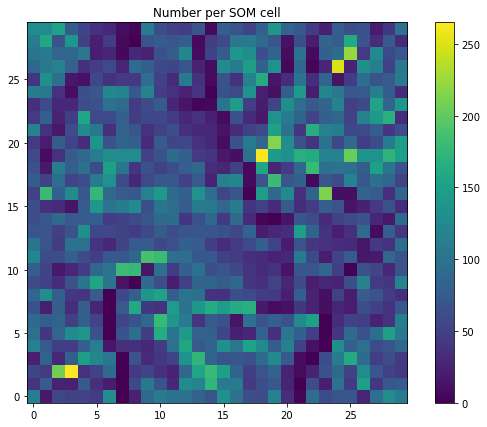

In [66]:
plot_somz_counts()

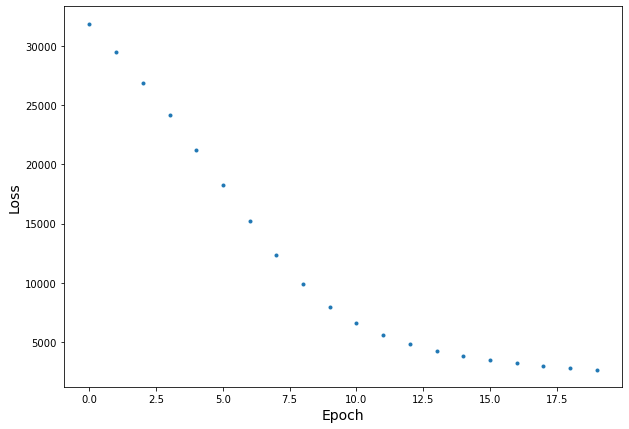

In [53]:
plot_somz_loss()

In [81]:
pred = [np.mean(M.get_vals(som.table_to_array(X)[i])) for i in range(len(X))]
rms = [np.std(M.get_vals(som.table_to_array(X)[i])) for i in range(len(X))]

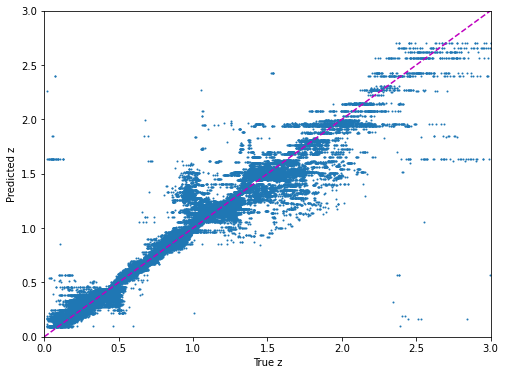

In [82]:
plt.figure(figsize=(8,6))
plt.scatter(Y, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

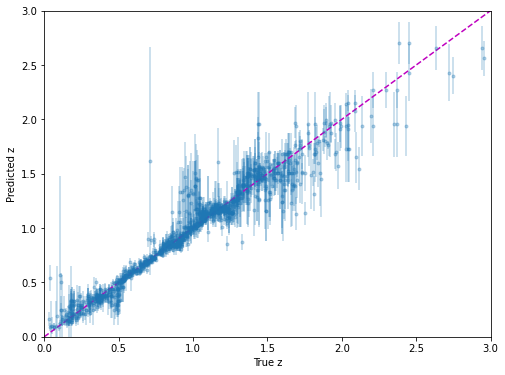

In [83]:
chunks = 50
plt.figure(figsize=(8,6))
plt.errorbar(x=Y[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

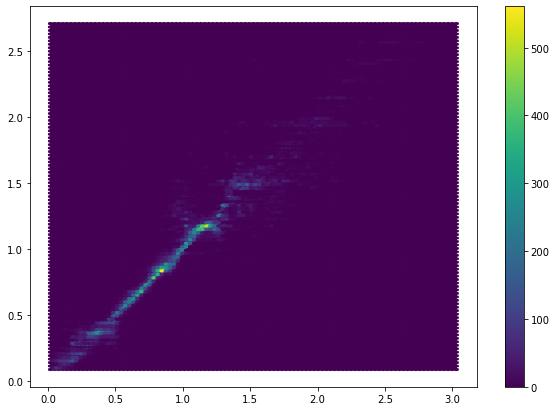

In [84]:
plt.figure(figsize=(10,7))
plt.hexbin(Y, pred, gridsize=(100,100))
plt.colorbar();

Map test data back to SOM:

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.9354169368743896


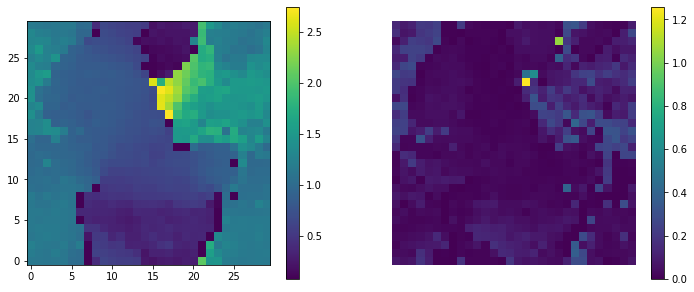

In [93]:
start = time.time()
M.evaluate_map(inputX=som.table_to_array(X_test), inputY=Y_test)
print(time.time() - start)
M.plot_map()

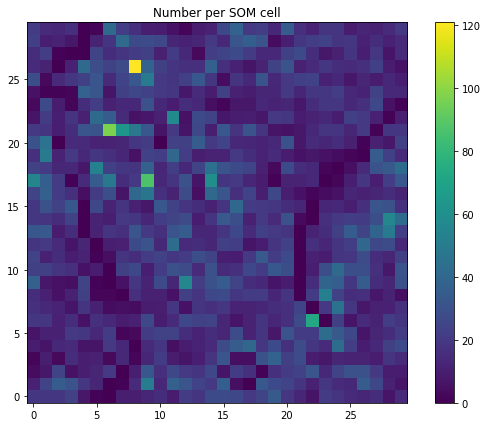

In [136]:
plot_somz_counts()

In [96]:
pred = [np.mean(M.get_vals(som.table_to_array(X_test)[i])) for i in range(len(X_test))]
rms = [np.std(M.get_vals(som.table_to_array(X_test)[i])) for i in range(len(X_test))]

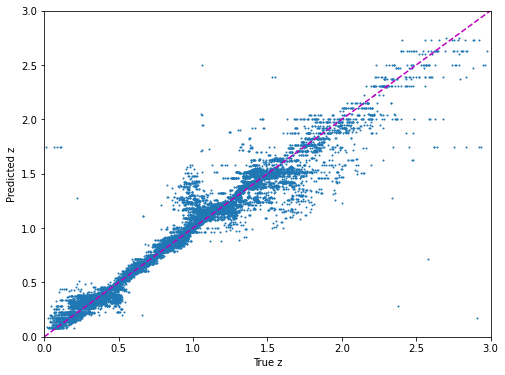

In [98]:
plt.figure(figsize=(8,6))
plt.scatter(Y_test, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

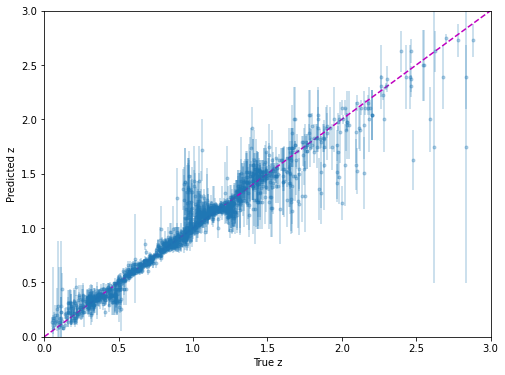

In [99]:
chunks = 10
plt.figure(figsize=(8,6))
plt.errorbar(x=Y_test[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

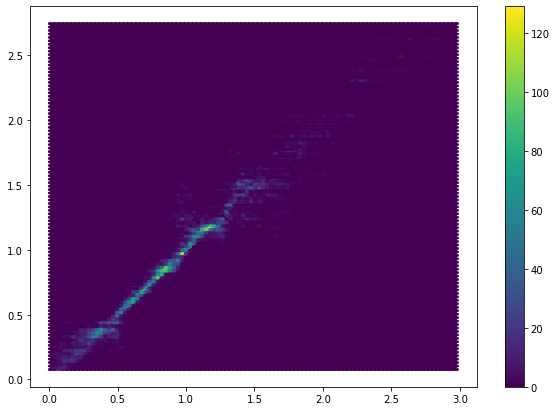

In [100]:
plt.figure(figsize=(10,7))
plt.hexbin(Y_test, pred, gridsize=(100,100))
plt.colorbar();